Deriving different QBO indices from the data

In [1]:
from scipy.io import netcdf
from matplotlib import pyplot as plt
import calculations as calc
from sklearn import preprocessing
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
nc_l30 = netcdf.netcdf_file("data/era-int_pl_1979-2019-mm-l30-u.nc")
reference_data = np.loadtxt( 'data/QBO_Singapore_Uvals_GSFC.txt' )

In [3]:
print(calc.derive.__doc__)


    Derive time series for a given index from a map.

    Args:
        map_array (numpy.ndarray): Map with 4 dimensions - time, level, latitude, longitude
        lat (int): Latitude of starting point
        lon (int): Longitude of starting point
        level (int, optional): Level from which the index should be derived
            Defaults to 0
        lat_step (int, optional): Stepsize in Latitude-dimension:
            How many points in the vertical direction should be taken into account.
            Defaults to 0
        lon_step (int, optional): Stepsize in Longitude-dimension:
            How many points in the horizontal direction should be taken into account.
            Defaults to 0

    Returns:
        List containing the mean values of all values in the respective index per time
    


<h2>Different definitions for QBO</h2>
<ol>
    <li>Values at Singapore (1N, 104E) at pressure level 30 hPa (qbo_singapore).</li>
    <li>Values at +- 5°north and south of the equator at pressure level 30 hPa (qbo_equator).</li>
    <li>Reference QBO found <a href="https://acd-ext.gsfc.nasa.gov/Data_services/met/qbo/QBO_Singapore_Uvals_GSFC.txt">Here</a>: Monthly-mean zonal wind data at Singapore (1N/104E) (qbo_reference)</li>
</ol>

<h3>1. Values at Singapore (1N, 104E) at pressure level 30 hPa</h3>

In [4]:
lon = calc.convert_coordinates_to_grid(nc_l30.variables["longitude"][:], 104)
lat = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 1)

u_l30 = nc_l30.variables["u"]

qbo_singapore = calc.derive(u_l30[:,:,:,:], lon, lat, 0)

Number of datapoints taken into account to derive QBO at given month: 1 

<h3>2. Values at +- 5°north and south of the equator at pressure level 30 hPa</h3>

In [5]:
lon = calc.convert_coordinates_to_grid(nc_l30.variables["longitude"][:], 180)
lat = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 0)

lon_step = 256 #Around the whole equator
lat_step = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 0) - calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 5)

qbo_equator = calc.derive(u_l30[:, :, :, :], lon, lat, 0, lon_step, lat_step)

In [6]:
lat_step

7

Number of datapoints taken into account to derive QBO at given month: (2 * 7 + 1) * 512 = 7680

<h3>3. Reference QBO found <a href="https://acd-ext.gsfc.nasa.gov/Data_services/met/qbo/QBO_Singapore_Uvals_GSFC.txt">Here</a>: Monthly-mean zonal wind data at Singapore (1N/104E)</h3>

In [7]:
qbo_reference = reference_data[:480, 8] # values from 1979-2019 (480) and pressure level 30 hPa (column 8)

<h2>Plotting the different QBO indices</h2>

In [8]:
x_ticks = np.array(np.arange(0, 481, 60))
x_ticklabels = np.array(np.arange(1979, 2020, 5))

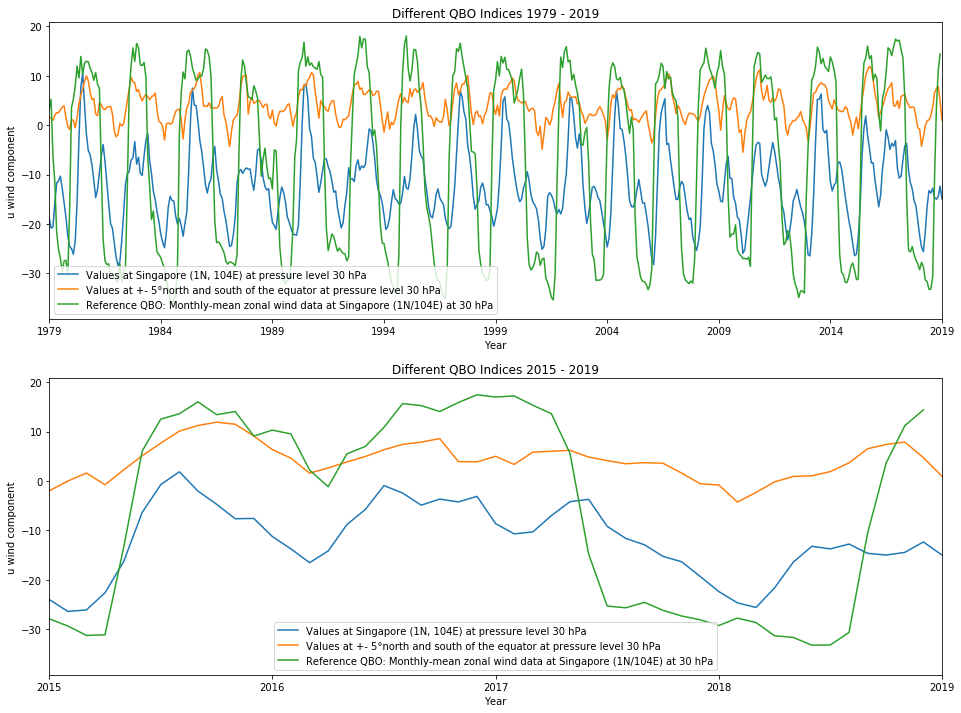

In [9]:
fig, ax = plt.subplots(2, figsize=[16, 12])
ax[0].plot(qbo_singapore, label="Values at Singapore (1N, 104E) at pressure level 30 hPa")
ax[0].plot(qbo_equator, label="Values at +- 5°north and south of the equator at pressure level 30 hPa")
ax[0].plot(qbo_reference, label="Reference QBO: Monthly-mean zonal wind data at Singapore (1N/104E) at 30 hPa")
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_ticklabels)
ax[0].set_xlim([0,480])
ax[0].set_xlabel("Year")
ax[0].set_ylabel("u wind component")
ax[0].set_title("Different QBO Indices 1979 - 2019")
ax[0].legend()

ax[1].plot(qbo_singapore, label="Values at Singapore (1N, 104E) at pressure level 30 hPa")
ax[1].plot(qbo_equator, label="Values at +- 5°north and south of the equator at pressure level 30 hPa")
ax[1].plot(qbo_reference, label="Reference QBO: Monthly-mean zonal wind data at Singapore (1N/104E) at 30 hPa")
ax[1].set_xticks([432, 444, 456, 468, 480])
ax[1].set_xticklabels([2015, 2016, 2017, 2018, 2019])
ax[1].set_xlim([432,480])
ax[1].set_xlabel("Year")
ax[1].set_ylabel("u wind component")
ax[1].set_title("Different QBO Indices 2015 - 2019")
ax[1].legend()

plt.show()

<h3>Deseasonalize data </h3>

In [10]:
u_l30_deseasonalized = calc.deseasonalize_map(u_l30)

print(calc.deseasonalize_map.__doc__)


    Deseasonalize every data point of a map by subtracting the respective mean and dividing by
    the respective standard deviation.

    For example: Monthly (period_length = 12). From each value, subtract the alltime
    mean for this month and divide by the alltime standard deviation for this month.

    If the length of the time dimension is no multiple of the period length, values from behind
    will be dropped until this condition is met.

    Args:
        map_array (np.ndarray): Map with 4 dimensions - time, level, latitude, longitude
        period_length (int): length of one period
            Defaults to 12

    Returns:
        Deseasonalized map
    


<h3>Derive QBO from deseasonalized data</h3>

In [11]:
#Values at Singapore (1N, 104E) at pressure level 30 hPa
lon = calc.convert_coordinates_to_grid(nc_l30.variables["longitude"][:], 104)
lat = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 1)

qbo_singapore_deseasonalized = calc.derive(u_l30_deseasonalized[:,:,:,:], lon, lat, 0)

#Values at +- 5°north and south of the equator at pressure level 30 hPa
lon = calc.convert_coordinates_to_grid(nc_l30.variables["longitude"][:], 180)
lat = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 0)

lon_step = 256 #Around the whole equator
lat_step = calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 0) - calc.convert_coordinates_to_grid(nc_l30.variables["latitude"][:], 5)

qbo_equator_deseasonalized = calc.derive(u_l30_deseasonalized[:, :, :, :], lon, lat, 0, lon_step, lat_step)

In [12]:
qbo_reference_normalized = preprocessing.scale(qbo_reference)

<h2>Plotting the deseasonalized QBO indices</h2>

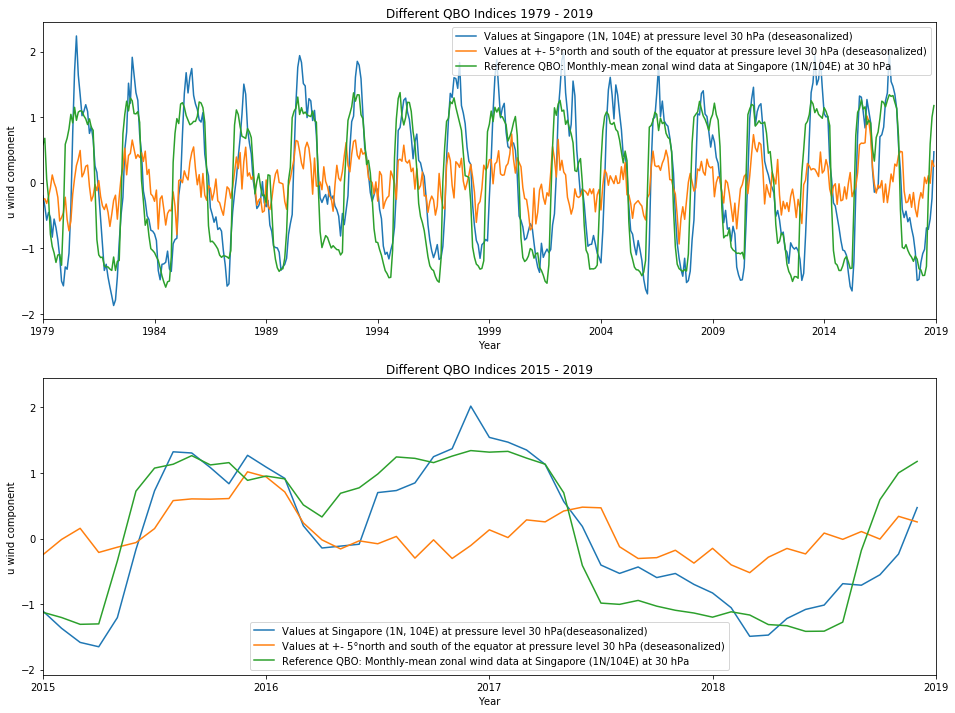

In [13]:
fig, ax = plt.subplots(2, figsize=[16, 12])
ax[0].plot(qbo_singapore_deseasonalized, label="Values at Singapore (1N, 104E) at pressure level 30 hPa (deseasonalized)")
ax[0].plot(qbo_equator_deseasonalized, label="Values at +- 5°north and south of the equator at pressure level 30 hPa (deseasonalized)")
ax[0].plot(qbo_reference_normalized, label="Reference QBO: Monthly-mean zonal wind data at Singapore (1N/104E) at 30 hPa")
ax[0].set_xticks(x_ticks)
ax[0].set_xticklabels(x_ticklabels)
ax[0].set_xlim([0,480])
ax[0].set_xlabel("Year")
ax[0].set_ylabel("u wind component")
ax[0].set_title("Different QBO Indices 1979 - 2019")
ax[0].legend()

ax[1].plot(qbo_singapore_deseasonalized, label="Values at Singapore (1N, 104E) at pressure level 30 hPa(deseasonalized)")
ax[1].plot(qbo_equator_deseasonalized, label="Values at +- 5°north and south of the equator at pressure level 30 hPa (deseasonalized)")
ax[1].plot(qbo_reference_normalized, label="Reference QBO: Monthly-mean zonal wind data at Singapore (1N/104E) at 30 hPa")
ax[1].set_xticks([432, 444, 456, 468, 480])
ax[1].set_xticklabels([2015, 2016, 2017, 2018, 2019])
ax[1].set_xlim([432,480])
ax[1].set_xlabel("Year")
ax[1].set_ylabel("u wind component")
ax[1].set_title("Different QBO Indices 2015 - 2019")
ax[1].legend()

plt.show()